In [1]:
!pip install torch
!pip install qiskit
!pip install qiskit-aer-gpu
!pip install pylatexenc
!pip install qiskit_machine_learning
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (2: No such file or directory)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
# Query name of current folder
import os
folder_name=os.getcwd()
import pandas as pd

# Goto the Colab folder
folder_name=os.getcwd()
os.chdir('/global/homes/s/samuelyu/Training data')

In [3]:
import numpy as np
from typing import Optional, List
from qiskit.exceptions import QiskitError
from qiskit.circuit import QuantumRegister, QuantumCircuit, ParameterVector, Instruction
from qiskit.circuit.library import BlueprintCircuit,RealAmplitudes,EfficientSU2,PauliFeatureMap

from qiskit import ClassicalRegister
from qiskit.quantum_info import Statevector

import torch
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1
_ = torch.manual_seed(1)  # suppress output

In [4]:
num_qubits = 8 # number of qubits to use in the network
num_latent = 4 # number of qubits to use in each latent layer
num_trash = [2,2] # number of qubits to discard in each latent layer

def prep(metal):
    ret = []
    for filename in os.listdir(f"{metal}_select"):
        f = f"{metal}_select/{filename}"
        with open(f,'r') as file:
            s = file.read()
            while s.endswith('\n'):
                s = s.rstrip('\n')
            # Read the contents line by line
        #    lines = file.readlines()
        #s = ""
        #for i in range(len(lines)):
        #    s += lines[i]
        ret.append(s)
    return ret

In [5]:
import json
# now we want to create the right metal code as supplied
metals = ['Fe', 'Ca', 'Se', 
          'Ni', 'Co', 'Cd', 'Hg']

def metal_code(s):
    s = format(metals.index(s), '0{}b'.format(4))
    ret = [2*np.arcsin(float(c)) for c in s]
    return ret

# Open the file in read mode
#with open('metal_dct.txt', 'r') as file:
metal_dct = {} # json.load(file)

In [6]:
metal_dct["Ca"] = prep("Ca")
#metal_dct["Cd"] = prep("Cd")
#metal_dct["Co"] = prep("Co")
#metal_dct["Cu"] = prep("Cu")
#metal_dct["Fe"] = prep("Fe")
#metal_dct["Hg"] = prep("Hg")
#metal_dct["K"] = prep("K")
#metal_dct["Mg"] = prep("Mg")
#metal_dct["Mn"] = prep("Mn")
#metal_dct["Na"] = prep("Na")
#metal_dct["Ni"] = prep("Ni")
#metal_dct["Pb"] = prep("Pb")
#metal_dct["Se"] = prep("Se")

In [7]:
# Define a function to encode the amino acid sequence into a vector of qubit states
def encode_amino_acid_sequence(sequence, max_len=2**num_qubits):
    # Define a dictionary to map each amino acid to a unique binary string
    amino_acid_dict = {'-': 0, 'A': 1, 'C': 2, 'D': 3,
                       'E': 4, 'F': 5, 'G': 6, 'H': 7,
                       'I': 8, 'K': 9, 'L': 10, 'M': 11,
                       'N': 12, 'P': 13, 'Q': 14, 'R': 15,
                       'S': 16, 'T': 17, 'V': 18, 'W': 19,
                       'Y': 20, '\n': 21}

    # Create a binary string representing the amino acid sequence
    seq_mod = sequence
    state_vector = []
    if len(seq_mod) <= max_len and len(seq_mod) > 0:
        seq_mod += "-" * (max_len-len(seq_mod))

        for aa in seq_mod:
            state_vector.append(amino_acid_dict[aa])

        # Convert the binary string to a vector of qubit states
        state_vector /= np.linalg.norm(state_vector)
    return state_vector

In [8]:
# create matching training input/output sets
input_states = []
for m in metals:
    if m in metal_dct.keys():
        # input vector = amino acid vector + metal vector
        n = len(metal_dct[m])
        M = np.array(metal_code(m))
        for i in metal_dct[m][:n//1]:
            I = encode_amino_acid_sequence(i)
            if len(I) > 0:
                I = np.array(I)
                I = np.concatenate((I, M))
                input_states.append(I)

input_states = np.array(input_states)
train_input = input_states

In [9]:
print(len(input_states))

210


In [10]:
class RawFeatureVector(BlueprintCircuit):
    def __init__(self, feature_dimension: Optional[int], name: str) -> None:
        """
        Args:
            feature_dimension: The feature dimension from which the number of
                                qubits is inferred as ``n_qubits = log2(feature_dim)``
        """
        super().__init__()

        self._ordered_parameters = ParameterVector(name)
        if feature_dimension is not None:
            self.feature_dimension = feature_dimension

    def _build(self):
        super()._build()

        placeholder = ParameterizedInitialize(self._ordered_parameters[:])
        self.append(placeholder, self.qubits)

    def _unsorted_parameters(self):
        if self.data is None:
            self._build()
        return super()._unsorted_parameters()

    def _check_configuration(self, raise_on_failure=True):
        if isinstance(self._ordered_parameters, ParameterVector):
            self._ordered_parameters.resize(self.feature_dimension)
        elif len(self._ordered_parameters) != self.feature_dimension:
            if raise_on_failure:
                raise ValueError("Mismatching number of parameters and feature dimension.")
            return False
        return True

    @property
    def num_qubits(self) -> int:
        """Returns the number of qubits in this circuit.

        Returns:
            The number of qubits.
        """
        return super().num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        """Set the number of qubits for the n-local circuit.

        Args:
            The new number of qubits.
        """
        if self.num_qubits != num_qubits:
            # invalidate the circuit
            self._invalidate()
            self.qregs: List[QuantumRegister] = []
            if num_qubits is not None and num_qubits > 0:
                self.qregs = [QuantumRegister(num_qubits, name="q")]

    @property
    def feature_dimension(self) -> int:
        """Return the feature dimension.

        Returns:
            The feature dimension, which is ``2 ** num_qubits``.
        """
        return 2**self.num_qubits

    @feature_dimension.setter
    def feature_dimension(self, feature_dimension: int) -> None:
        """Set the feature dimension.

        Args:
            feature_dimension: The new feature dimension. Must be a power of 2.

        Raises:
            ValueError: If ``feature_dimension`` is not a power of 2.
        """
        num_qubits = np.log2(feature_dimension)
        if int(num_qubits) != num_qubits:
            raise ValueError("feature_dimension must be a power of 2!")

        if num_qubits != self.num_qubits:
            self._invalidate()
            self.num_qubits = int(num_qubits)


class ParameterizedInitialize(Instruction):
    """A normalized parameterized initialize instruction."""

    def __init__(self, amplitudes):
        num_qubits = np.log2(len(amplitudes))
        if int(num_qubits) != num_qubits:
            raise ValueError("feature_dimension must be a power of 2!")

        super().__init__("ParameterizedInitialize", int(num_qubits), 0, amplitudes)

    def _define(self):
        # cast ParameterExpressions that are fully bound to numbers
        cleaned_params = []
        for param in self.params:
            # print(param)
            #if param == 0: # .parameters
            cleaned_params.append(complex(param))
            #else:
            #    raise QiskitError("Cannot define a ParameterizedInitialize with unbound parameters")

        # normalize
        normalized = np.array(cleaned_params) / np.linalg.norm(cleaned_params)

        circuit = QuantumCircuit(self.num_qubits)
        circuit.initialize(normalized, range(self.num_qubits))
        self.definition = circuit

In [11]:
#from raw_feature_vector import RawFeatureVector
def ansatz_RA(num_qubits,pref,reps=1):
    return RealAmplitudes(num_qubits, reps=reps, parameter_prefix=pref)

fm_i = RawFeatureVector(2**(num_qubits), "i")

c2 = QuantumCircuit(sum(num_trash))
fm_m = ParameterVector("m", sum(num_trash)) # RawFeatureVector(2**(sum(num_trash)), "m")
for i in range(sum(num_trash)):
    c2.ry(fm_m[i], i)

def encoder():
    qc = QuantumCircuit(num_qubits + sum(num_trash) + 1)

    # encoder layer
    ae0 = ansatz_RA(num_qubits, 'alpha', 2)
    qc = qc.compose(ae0, qubits=range(num_qubits))
    #ae1 = ansatz_RA(num_units, 'beta', 1)
    #qc = qc.compose(ae1, qubits=range(num_units))

    ae2 = ansatz_RA(num_qubits-num_trash[0], 'gamma', 2)
    qc = qc.compose(ae2, qubits=range(num_qubits-num_trash[0]))
    #ae3 = ansatz_RA(num_units-1, 'delta', 1)
    #qc = qc.compose(ae3, qubits=range(num_units-1))

    qc.barrier()

    return qc

enc = encoder()

In [12]:
from qiskit.circuit.parametertable import ParameterView
# Create a circuit with parameters1
c1 = QuantumCircuit(num_qubits)
c1 = c1.compose(fm_i)

# Extract parameters from both circuits
p1 = c1.parameters
p2 = c2.parameters

# Create a new ParameterView and add parameters from both circuits
combined_p = list(p1) + list(p2)
combined_p = ParameterView(combined_p)

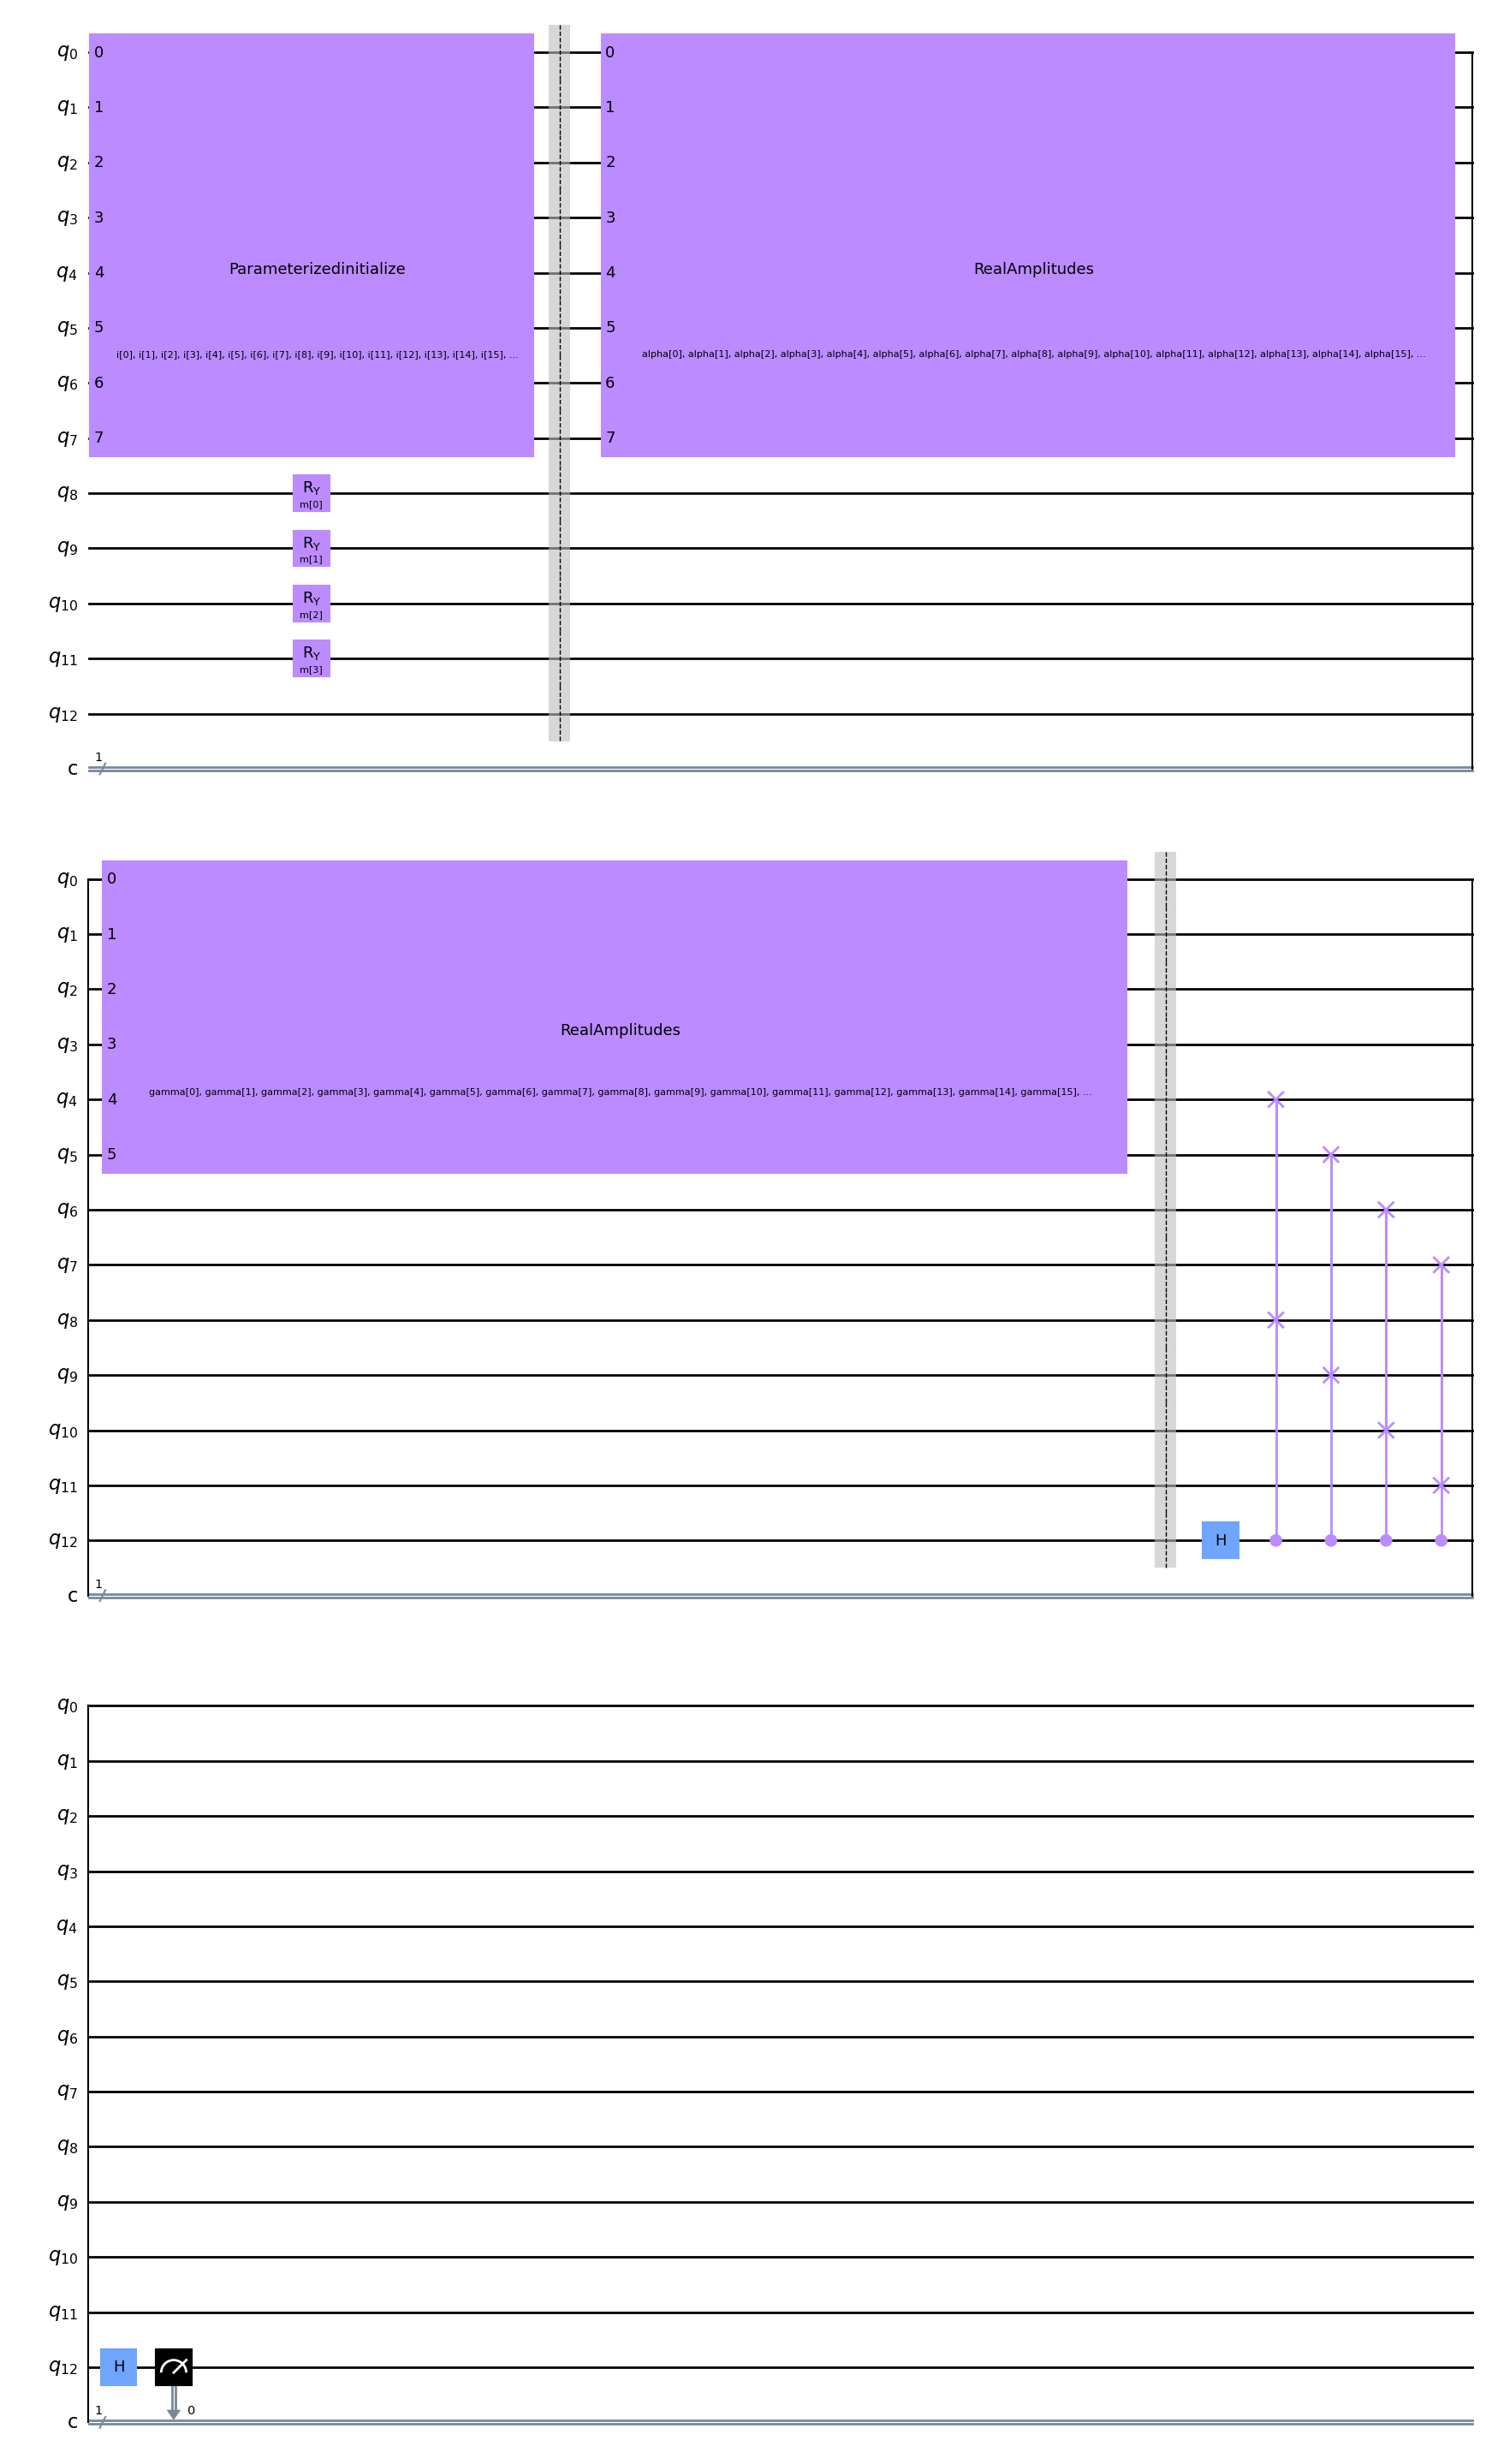

In [13]:
# contruct variaitonal autoencode structure
def enc_train():
    qr = QuantumRegister(num_qubits + sum(num_trash) + 1, "q")
    cr = ClassicalRegister(1, "c")
    c = QuantumCircuit(qr, cr)
    aux = num_qubits + sum(num_trash)

    c = c.compose(fm_i, range(num_qubits))
    c = c.compose(c2, range( num_qubits, num_qubits+sum(num_trash) ))
    c.barrier()

    # encoder layer
    c = c.compose(enc)

    c.h(aux)
    for i in range(sum(num_trash)):
        c.cswap(aux, num_latent + i, num_qubits + i)
    c.h(aux)
    c.measure(aux, cr[0])

    return c

c = enc_train()
c.draw("mpl")

In [14]:
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

shots = 8000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x

qnn = SamplerQNN(
    circuit=c, sampler=sampler,
    input_params=combined_p,
    weight_params=enc.parameters,
    sparse=False,
    interpret=identity_interpret,
    output_shape=2,
)

In [15]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
objective_func_vals = []

def cost(params_values): # trial
    probabilities = qnn.forward(train_input, params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:,1]) / len(train_input)

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration", fontsize=18)
    plt.xlabel("Iteration", fontsize=15)
    plt.ylabel("Objective function value", fontsize=15)
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

In [15]:
# Read the data from the text file
with open('opt_result.txt', 'r') as file:
    x0 = [float(line.strip()) for line in file]
with open('objective_func_vals.txt', 'r') as file:
    objective_func_vals = [float(line.strip()) for line in file]

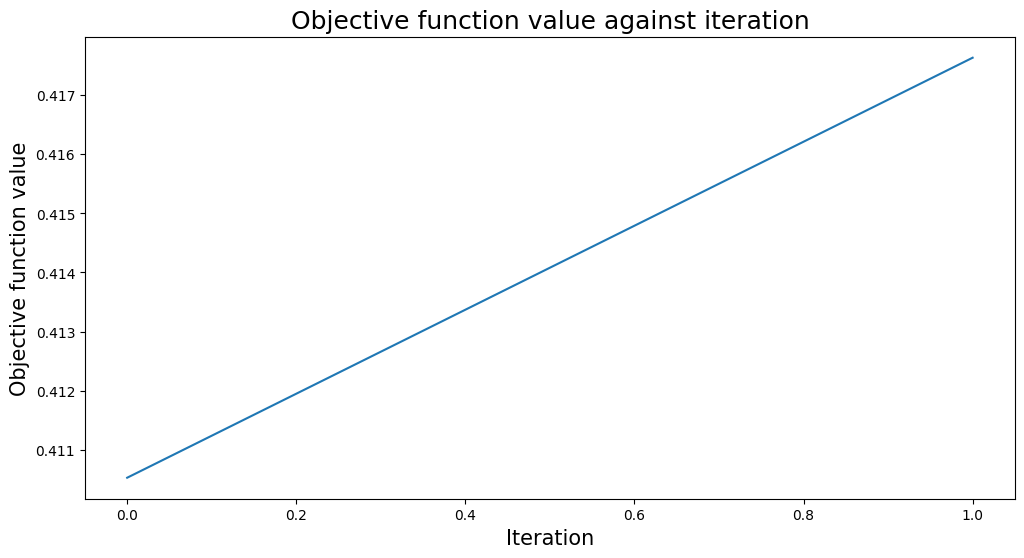

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [16]:
import time
from scipy.optimize import minimize
#from optimize import minimize
from qiskit.algorithms.optimizers import COBYLA
opt = COBYLA(maxiter=300)

# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost, x0=algorithm_globals.random.random(enc.num_parameters)) # x0
# Initial parameter guess for the optimization
#initial_params = algorithm_globals.random.random(enc.num_parameters)

# Define options for the optimizer
#options = {'maxiter': 10}

# Optimize using L-BFGS-B
#result = minimize(cost, initial_params, method='SLSQP', options=options)
hours = (time.time()-start) // 3600
minutes = ((time.time()-start) % 3600) // 60
print(f"Fit in {hours} hours, {minutes} minutes")

In [24]:
# Save the list of floats to a text file
np.savetxt('/global/homes/s/samuelyu/Training data/opt_result.txt', opt_result.x)
np.savetxt("/global/homes/s/samuelyu/Training data/objective_func_vals.txt", objective_func_vals)

In [18]:
def enc():
    qc = QuantumCircuit(num_qubits)

    # encoder layer
    ae0 = ansatz_RA(num_qubits, 'alpha', 2)
    qc = qc.compose(ae0, qubits=range(num_qubits))
    #ae1 = ansatz_RA(num_units, 'beta', 1)
    #qc = qc.compose(ae1, qubits=range(num_units))

    ae2 = ansatz_RA(num_qubits-num_trash[0], 'gamma', 2)
    qc = qc.compose(ae2, qubits=range(num_qubits-num_trash[0]))
    #ae3 = ansatz_RA(num_units-1, 'delta', 1)
    #qc = qc.compose(ae3, qubits=range(num_units-1))

    qc.barrier()

    return qc

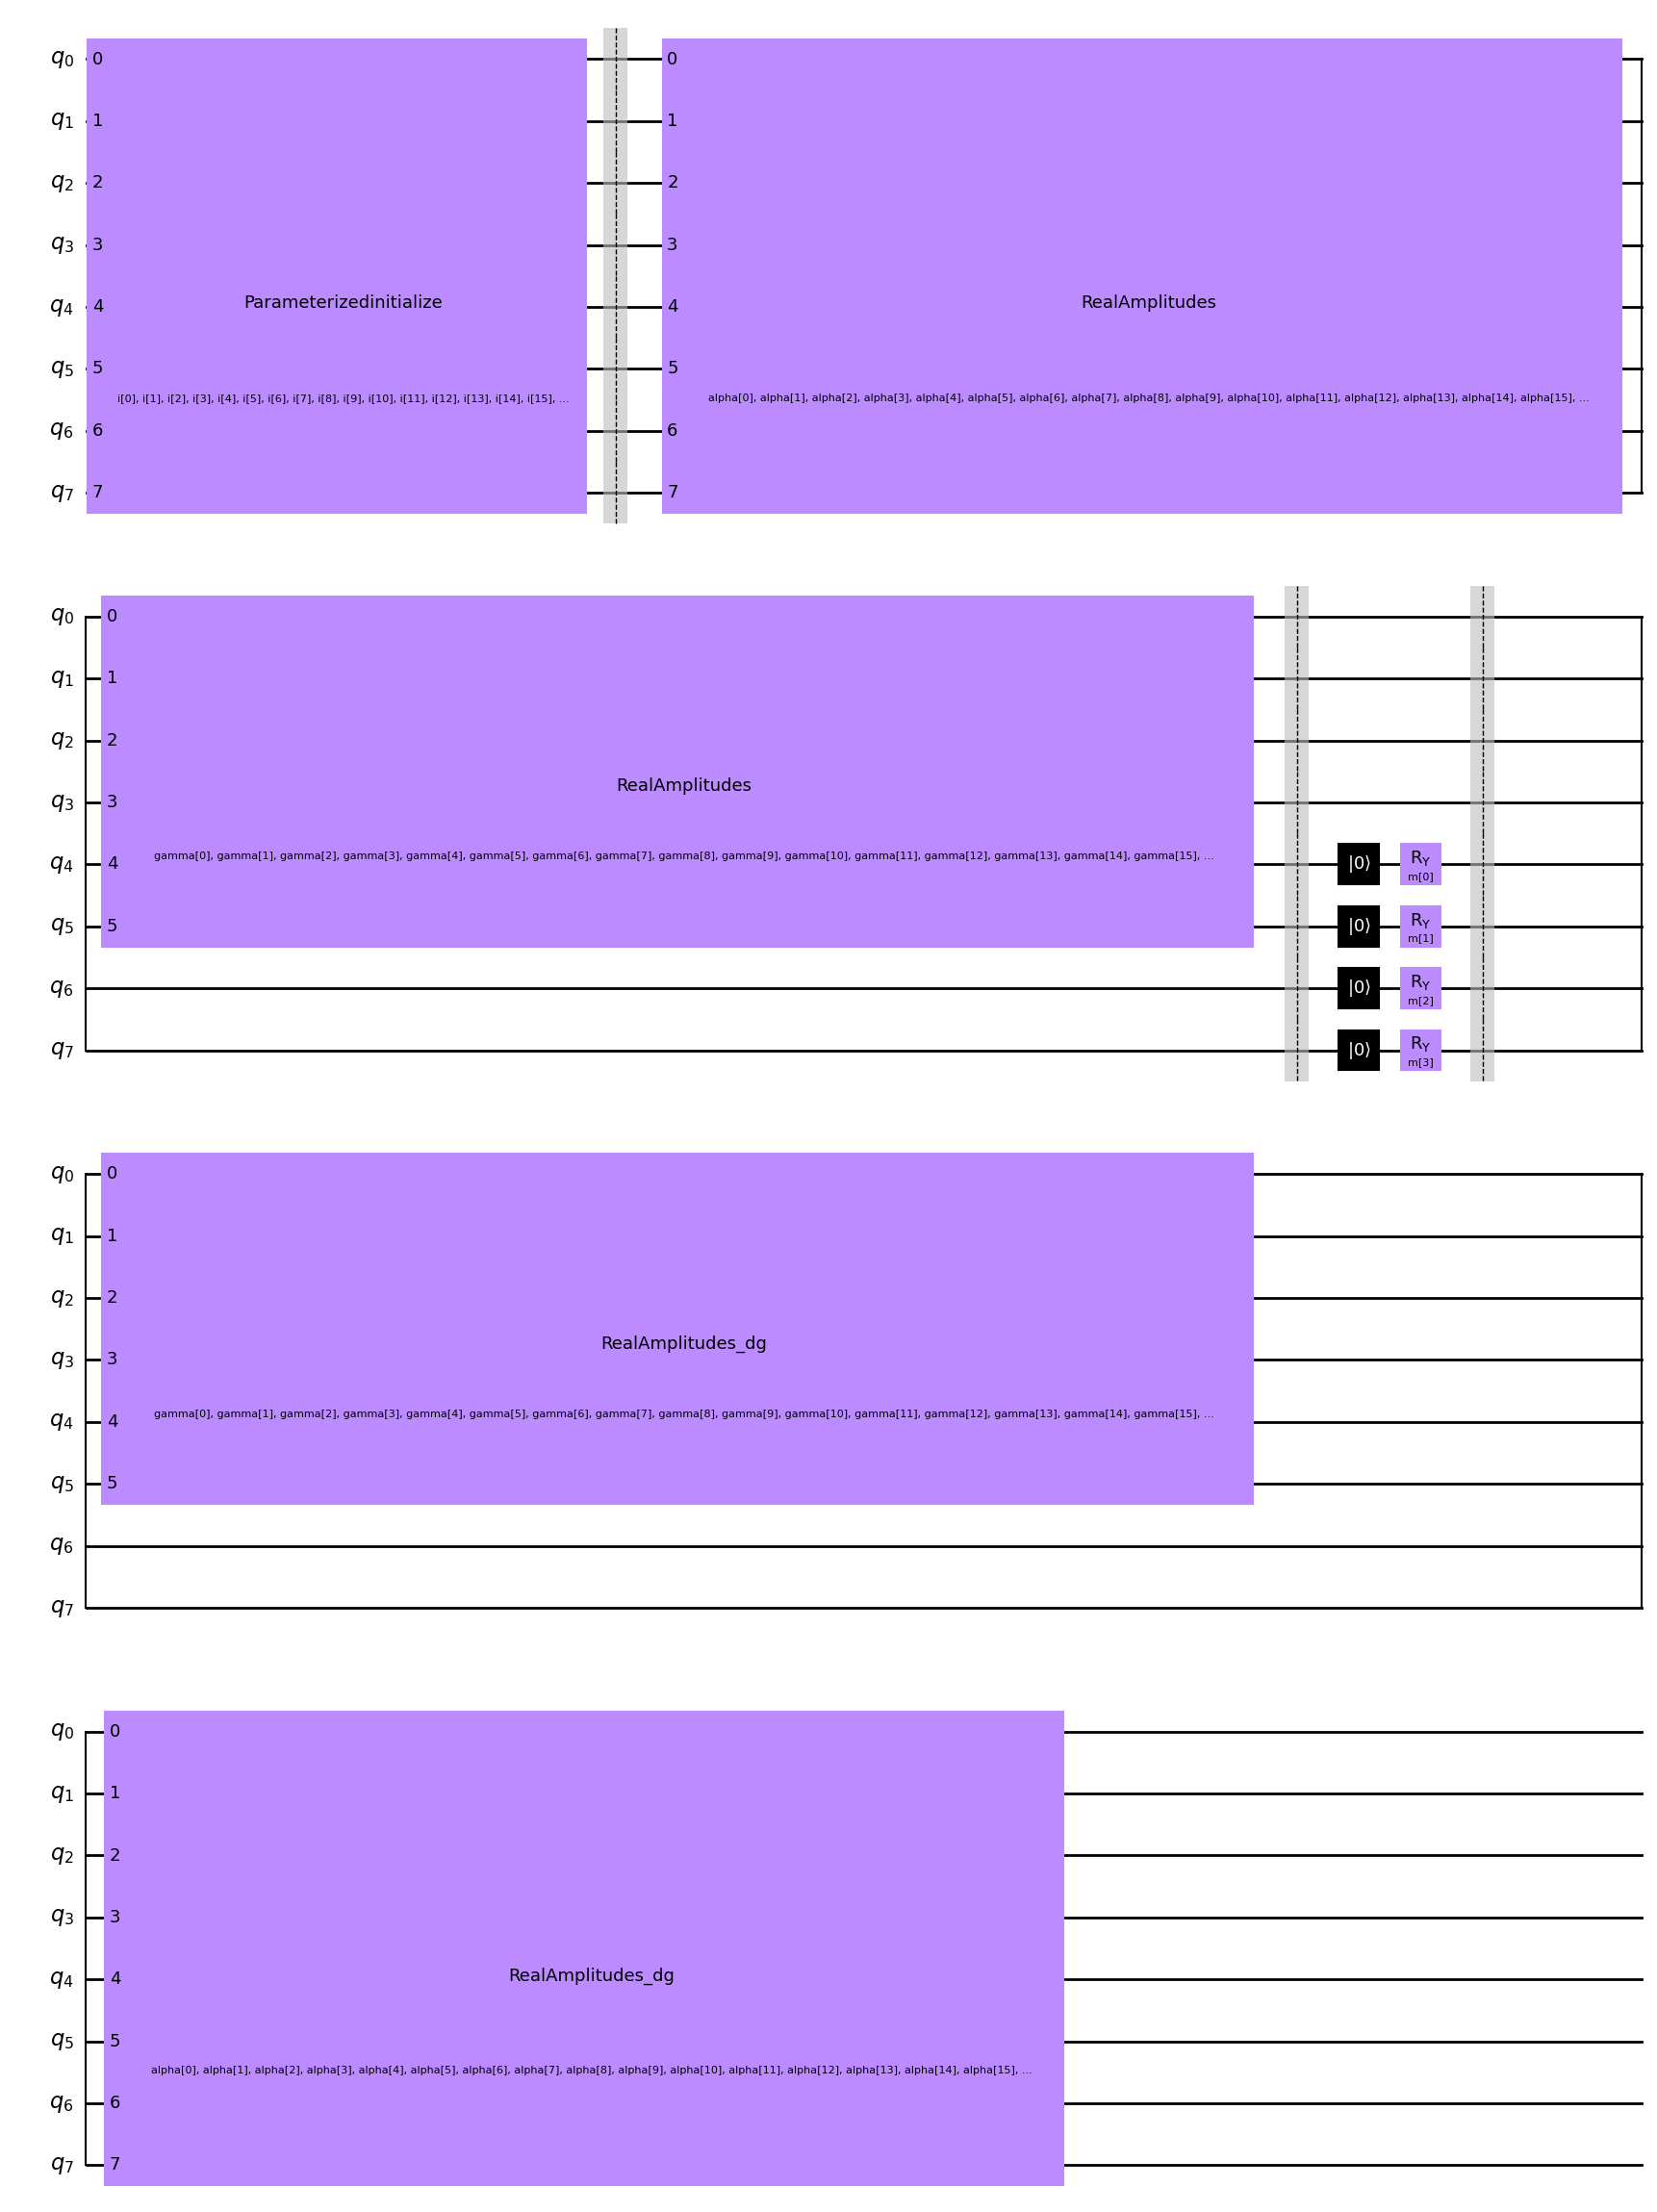

In [19]:
# Test
test_qc = QuantumCircuit(num_qubits)
test_qc = test_qc.compose(fm_i, range(num_qubits))
test_qc.barrier()

ansatz_qc = enc()
test_qc = test_qc.compose(ansatz_qc)

fm_m = ParameterVector("m", sum(num_trash))
for i in range(num_latent, num_qubits):
    test_qc.reset(i)
    test_qc.ry(fm_m[i-num_latent], i)

test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw("mpl")

In [29]:
print(train_input)

[[0.1354725  0.11084114 0.11084114 0.24631364 0.20936659 0.02463136
  0.20936659 0.22168227 0.02463136 0.01231568 0.24631364 0.09852545
  0.24631364 0.14778818 0.16010386 0.04926273 0.03694705 0.07389409
  0.03694705 0.16010386 0.03694705 0.14778818 0.07389409 0.22168227
  0.14778818 0.16010386 0.07389409 0.20936659 0.03694705 0.06157841
  0.11084114 0.03694705 0.09852545 0.16010386 0.03694705 0.03694705
  0.23399796 0.22168227 0.02463136 0.16010386 0.12315682 0.02463136
  0.07389409 0.22168227 0.07389409 0.11084114 0.03694705 0.17241955
  0.06157841 0.04926273 0.04926273 0.22168227 0.04926273 0.04926273
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.  

In [28]:
fid = []
# test VAE
for i in range(len(train_input)):
    original_qc = fm_i.assign_parameters(input_states[i,:2**num_qubits])
    original_sv = Statevector(original_qc).data
    #print(original_sv)

    param_values = np.concatenate((input_states[i,:2**num_qubits], x0, input_states[i,2**num_qubits:]))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    #print(output_sv)

    fidelity = np.sqrt(np.dot(original_sv.conj(), output_sv) ** 2)
    fid.append(fidelity.real)
    print(fidelity.real)
    print()

0.05249790008020192

0.10990037519495079



In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(5,5),dpi=80)
plt.hist(np.array(fid), 150)

plt.xlabel("Fidelity", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.tick_params(labelsize=15)
plt.style.use(['seaborn-paper'])
plt.rc("font", family="Times New Roman")
plt.show()
#plt.savefig("f_correct.png",dpi = 300,bbox_inches='tight')